In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
np.__version__, torch.__version__

('1.21.6', '1.13.1+cu116')

In [3]:
import matplotlib
matplotlib.__version__

'3.2.2'

## Loading Data

In [4]:
# defining corpus

corpus = ["apple banana fruit", "banana apple fruit", "banana fruit apple", 
          "dog cat animal", "cat dog animal", "cat animal dog"]

In [5]:
# tokenization

corpus_tokenized = [sent.split(" ") for sent in corpus]
corpus_tokenized  # we called each of this as "tokens", NOT words

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'dog', 'animal'],
 ['cat', 'animal', 'dog']]

In [6]:
# numericalization

# getting all the unique words
# we want to flatten this (basically merge all list)

flatten = lambda l: [item for sublist in l for item in sublist]
vocabs  = list(set(flatten(corpus_tokenized)))  # vocabs is a term defining all unique words your system know

In [7]:
# assigning id to all these vocabs

word2index = {v: idx for idx, v in enumerate(vocabs)}

In [8]:
word2index

{'animal': 0, 'apple': 1, 'banana': 2, 'cat': 3, 'dog': 4, 'fruit': 5}

In [9]:
# adding <UNK>, which is a very normal token exists in the world

vocabs.append('<UNK>')

In [10]:
# now we have a way to know what is the id of <UNK>

word2index['<UNK>'] = 6

In [11]:
# creating index2word dictionary
   
index2word = {v:k for k, v in word2index.items()}
index2word

{0: 'animal',
 1: 'apple',
 2: 'banana',
 3: 'cat',
 4: 'dog',
 5: 'fruit',
 6: '<UNK>'}

In [12]:
vocabs

['animal', 'apple', 'banana', 'cat', 'dog', 'fruit', '<UNK>']

## Co-occurrence matrix

In [13]:
# using Counter to first count stuffs
from collections import Counter

# print(corpus_tokenized)

# counting the frequency of each word....
# we somehow need this to calculate the probability Pi
X_i = Counter(flatten(corpus_tokenized)) # merging all list....(flatten is a function I define.....)

# X_i['apple'] #get the probability of apple

In [14]:
corpus_tokenized

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'dog', 'animal'],
 ['cat', 'animal', 'dog']]

In [15]:
# defining a skipgram of window size 1
skip_grams = []

# looping through each corpus
for sent in corpus_tokenized:  #['apple', 'banana', 'fruit']
    # looping through each word from 1 to n-1 (because 0 and n has no context window)
    for i in range(1, len(sent)-1):
        target  = sent[i]
        context = [sent[i+1], sent[i-1]]
        # appending(i, i+1) and (i, i-1)
        for c in context:
            skip_grams.append((target, c))

In [16]:
corpus_tokenized

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'dog', 'animal'],
 ['cat', 'animal', 'dog']]

In [17]:
skip_grams

[('banana', 'fruit'),
 ('banana', 'apple'),
 ('apple', 'fruit'),
 ('apple', 'banana'),
 ('fruit', 'apple'),
 ('fruit', 'banana'),
 ('cat', 'animal'),
 ('cat', 'dog'),
 ('dog', 'animal'),
 ('dog', 'cat'),
 ('animal', 'dog'),
 ('animal', 'cat')]

In [18]:
# since we have these occurrences, we can count, to make our co-occurrence matrix!!!
X_ik_skipgram = Counter(skip_grams)
X_ik_skipgram

Counter({('banana', 'fruit'): 1,
         ('banana', 'apple'): 1,
         ('apple', 'fruit'): 1,
         ('apple', 'banana'): 1,
         ('fruit', 'apple'): 1,
         ('fruit', 'banana'): 1,
         ('cat', 'animal'): 1,
         ('cat', 'dog'): 1,
         ('dog', 'animal'): 1,
         ('dog', 'cat'): 1,
         ('animal', 'dog'): 1,
         ('animal', 'cat'): 1})

In [19]:
X_ik_skipgram[('banana', 'animal')]

0

In [20]:
X_ik_skipgram[('banana', 'apple')]

1

## Weighting Function f

In [21]:
def weighting(w_i, w_j, X_ik):   # we need w_i and w_j, because we can try its co-occurrences, if it's too big, we scale it down
    
    # checking whether the co-occurrences between these two word exists???
    try:
        x_ij = X_ik[(w_i, w_j)]
    except:
        x_ij = 1  # why one, so that the probability thingy won't break...(label smoothing)
        
    # maximum co-occurrences; we follow the paper
    x_max = 100
    alpha = 0.75
    
    # if the co-occurrences does not exceed x_max, scale it down based on some alpha
    if x_ij < x_max:
        result = (x_ij/x_max) ** alpha
    else:
        result = 1 # this is the maximum probability we can have
        
    return result

In [22]:
w_i  = 'banana'
w_j  = 'fruit'
w_j2 = 'chaky'

print(weighting(w_i, w_j, X_ik_skipgram))   # scales from 1 to 0.0316
print(weighting(w_i, w_j2, X_ik_skipgram))  # the paper says that f(0) = 0

0.03162277660168379
0.0


In [23]:
vocabs

['animal', 'apple', 'banana', 'cat', 'dog', 'fruit', '<UNK>']

In [24]:
# applying this weighting to all possible pairs
from itertools import combinations_with_replacement

X_ik = {} # for keeping the co-occurrences
weighting_dic = {} # for keeping all the probability after passing through the weighting function

for bigram in combinations_with_replacement(vocabs, 2):  # we need to also think its reverse
    # if this bigram exists in X_ik_skipgrams
    # we gonna add this to our co-occurence matrix
    if X_ik_skipgram.get(bigram) is not None:
        cooc = X_ik_skipgram[bigram]  # getting the co-occurrence
        X_ik[bigram] = cooc + 1 # this is again basically label smoothing....(stability issues (especially when divide something))
        X_ik[(bigram[1], bigram[0])] = cooc + 1  # trick to get all pairs
    else: # otherwise, do nothing
        pass
    
    # applying the weighting function using this co-occurrence matrix thingy    
    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

In [25]:
len(X_ik_skipgram)

12

In [26]:
X_ik

{('animal', 'cat'): 2,
 ('cat', 'animal'): 2,
 ('animal', 'dog'): 2,
 ('dog', 'animal'): 2,
 ('apple', 'banana'): 2,
 ('banana', 'apple'): 2,
 ('apple', 'fruit'): 2,
 ('fruit', 'apple'): 2,
 ('banana', 'fruit'): 2,
 ('fruit', 'banana'): 2,
 ('cat', 'dog'): 2,
 ('dog', 'cat'): 2}

## Preparing Train Data

In [27]:
for c in corpus_tokenized:
    print(c)

['apple', 'banana', 'fruit']
['banana', 'apple', 'fruit']
['banana', 'fruit', 'apple']
['dog', 'cat', 'animal']
['cat', 'dog', 'animal']
['cat', 'animal', 'dog']


In [28]:
skip_grams

[('banana', 'fruit'),
 ('banana', 'apple'),
 ('apple', 'fruit'),
 ('apple', 'banana'),
 ('fruit', 'apple'),
 ('fruit', 'banana'),
 ('cat', 'animal'),
 ('cat', 'dog'),
 ('dog', 'animal'),
 ('dog', 'cat'),
 ('animal', 'dog'),
 ('animal', 'cat')]

In [29]:
import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    # looping through this skipgram, and changing it to id  because when sending model, it must have a number
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    # randomly picking "batch_size" indexes
    number_of_choices = len(skip_grams_id)
    random_index = np.random.choice(number_of_choices, batch_size, replace=False) # no repeating indexes among these random indexes
    
    random_inputs = [] #xi, wi (in batches)
    random_labels = [] #xj, wj (in batches)
    random_coocs  = [] #Xij (in batches)
    random_weighting = [] #f(Xij) (in batches)
    # for each of the sample in these indexes
    for i in random_index:
        random_inputs.append([skip_grams_id[i][0]]) # same reason why i put bracket here....
        random_labels.append([skip_grams_id[i][1]])
        
        # getting cooc
        # first checking whether it exists...
        pair = skip_grams[i]  #e.g., ('banana', 'fruit)
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1 #label smoothing
            
        random_coocs.append([math.log(cooc)])  # 1. why log, # 2. why bracket -> size ==> (, 1)  # my neural network expects (, 1)
        
        # getting weighting
        weighting = weighting_dic[pair]  # why not use try....maybe it does not exist....
        random_weighting.append(weighting)

        
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weighting)
    

In [30]:
batch_size = 2
input, target, cooc, weightin = random_batch(batch_size, corpus_tokenized, skip_grams, X_ik, weighting_dic)

In [31]:
input, target, cooc, weightin

(array([[1],
        [2]]), array([[2],
        [5]]), array([[0.69314718],
        [0.69314718]]), array([0.05318296, 0.05318296]))

## Modeling

In [32]:
class GloVe(nn.Module):
    
    def __init__(self, vocab_size,embed_size):
        super(GloVe,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, embed_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, embed_size) # out embedding
        
        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)
        
    def forward(self, center_words, target_words, coocs, weighting):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        
        center_bias = self.v_bias(center_words).squeeze(1)
        target_bias = self.u_bias(target_words).squeeze(1)
        
        inner_product = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        #note that coocs already got log
        loss = weighting*torch.pow(inner_product +center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

## Training

In [33]:
voc_size = len(vocabs)
batch_size = 2 # why?  no reason; 
emb_size = 2 # why?  no reason; usually 50, 100, 300, but 2 so we can plot (we can also plot 50, but we need to do PCA)
model = GloVe(voc_size, emb_size)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [34]:
num_epochs = 5000
# for epoch
for epoch in range(num_epochs):

    # getting random batch
    input, target, cooc, weightin = random_batch(batch_size, corpus_tokenized, skip_grams, X_ik, weighting_dic)
    input_batch    = torch.LongTensor(input)
    target_batch   = torch.LongTensor(target)
    cooc_batch     = torch.FloatTensor(cooc)
    weightin_batch = torch.FloatTensor(weightin)
       
    # print(input_batch.shape, label_batch.shape, cooc_batch.shape, weightin_batch)
    
    # loss = model
    loss = model(input_batch, target_batch, cooc_batch, weightin_batch)
    
    # backpropagation
    loss.backward()
    
    # updating alpha
    optimizer.step()
    
    # printing epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: ??")

Epoch 1000 | Loss: 0.019917 | Time: ??
Epoch 2000 | Loss: 0.106383 | Time: ??
Epoch 3000 | Loss: 0.408712 | Time: ??
Epoch 4000 | Loss: 0.026751 | Time: ??
Epoch 5000 | Loss: 0.164411 | Time: ??


## Plot the Embeddings

In [35]:
vocabs

['animal', 'apple', 'banana', 'cat', 'dog', 'fruit', '<UNK>']

In [36]:
banana = torch.LongTensor([word2index['banana']])
banana

tensor([2])

In [37]:
banana_center_embed = model.embedding_v(banana)
banana_outisde_embed = model.embedding_u(banana)

banana_embed = (banana_center_embed + banana_outisde_embed) / 2
banana_embed

tensor([[ 0.9469, -0.2703]], grad_fn=<DivBackward0>)

In [39]:
def get_embed(word):
  
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
    
    word = torch.LongTensor([index])

    center_embed  = model.embedding_v(word)
    outside_embed = model.embedding_u(word)
    
    embed = (center_embed + outside_embed) / 2
    
    return  embed[0][0].item(), embed[0][1].item()

In [40]:
# finding embedding of fruit, cat

print(get_embed('fruit'))
print(get_embed('cat'))
print(get_embed('chaky'))

(-1.2961082458496094, -0.7323914766311646)
(-0.9956303834915161, 1.2956938743591309)
(-0.09982331097126007, -0.2264615148305893)


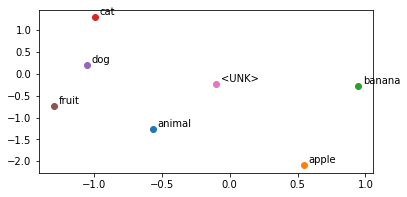

In [41]:
# plotting fruit cat banana on matplotlib

plt.figure(figsize=(6,3))
for i, word in enumerate(vocabs[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()